In [55]:
using Plots, Interact, Images;
using DataFrames, ExcelReaders;
# using Logging;
using ImageView
push!(LOAD_PATH, ".")
using ISCLib, Colors
using HypothesisTests, HDF5, NIfTI
using Distributions

In [1]:
🐱 = "cat"
abstract type Animal end    
struct 🐵 <: Animal
    has_tail::Bool
end

In [5]:
a = 🐵(true)


🐵(true)

In [30]:
function TTest(x::AbstractVector, y::AbstractVector, μ0=0)
    nx, ny = length(x), length(y)    
    m1, m2 = sum(x)/nx,sum(y)/ny
    xbar = m1-m2
    varx, vary = reduce((a,b)-> a+(b-m1).^2, x)/(nx-1), reduce((a,b)-> a+(b-m2).^2, y)/(ny-1)
    stderr = sqrt.(varx/nx + vary/ny)
    t = (xbar-μ0)./stderr    
    df = (varx ./ nx + vary ./ ny).^2 ./ ((varx / nx).^2 ./ (nx - 1) + (vary ./ ny).^2 / (ny - 1))
    (nx, ny, xbar, df, stderr, t)
end

sind = get_indexes(1,["S1","S2"]);
vind = get_indexes(1,["V1","V2","V3","V4"]);
S_seq = vcat([get_niis(1,sind[i,1]:sind[i,2]) for i =1:size(sind,1)]...);
V_seq = vcat([get_niis(1,vind[i,1]:vind[i,2]) for i =1:size(vind,1)]...);
(nx, ny, xbar, df, stderr, t) = TTest(S_seq,V_seq);

df = (x->isnan(x)?0:x).(df)
t = (x->isnan(x)?0:x).(t)
pvals = zeros(df)
for (i,(df_el,t_el)) = enumerate(zip(df,t))
    try
        pvals[i] = pvalue(TDist(df_el),t_el)
    catch
        pvals[i] = 1
    end
end

pvals
logpvals = -log10.(pvals);
logpvals[logpvals < 5] = 0
# logpvals[logpvals > 20] = 20
ni = get_nii(1,1)
res = NIfTI.NIVolume(ni.header, ni.extensions,logpvals) # Cheap, as reshape returns a view
niwrite("out/$pref|segmentation_result.nii",res)


In [96]:

logpvals = -log10.(pvals);
logpvals[logpvals .< 10] = 0
# logpvals[logpvals .> 20] = 20
# histogram(logpvals[0.<logpvals.<50], bins = 100)

ni = get_nii(1,1)
res = NIfTI.NIVolume(ni.header, ni.extensions,logpvals) # Cheap, as reshape returns a view
niwrite("out/Tstat|segmentation_result.nii",res)


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{UInt8}, ::Int64) at ./deprecated.jl:57
 [3] write(::IOStream, ::NIfTI.NIfTI1Header) at /home/ashedko/.julia/v0.6/NIfTI/src/NIfTI.jl:26
 [4] write(::IOStream, ::NIfTI.NIVolume{Float64,3,Array{Float64,3}}) at /home/ashedko/.julia/v0.6/NIfTI/src/NIfTI.jl:385
 [5] niwrite(::String, ::NIfTI.NIVolume{Float64,3,Array{Float64,3}}) at /home/ashedko/.julia/v0.6/NIfTI/src/NIfTI.jl:408
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/ashedko/.julia/v0.6/IJulia/src/execute_request.jl:160
 [7] eventloop(::ZMQ.Socket) at /home/ashedko/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##11#14)() at ./task.jl:335
while loading In[96], in expression starting on line 9


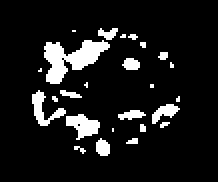

In [93]:
Gray.(logpvals[:,:,60])

In [26]:
log_p_values = -log10.(p_values)
map!(x->isnan(x)?0:x,log_p_values,log_p_values );
# log_p_values[log_p_values .> 100.] = 100.
log_p_values[log_p_values .< 5.] = 0.

0.0

In [32]:
count(isinf,log_p_values)
# histogram(log_p_values[log_p_values.>0])

168158

LoadError: [91mUndefVarError: ps not defined[39m

In [67]:
function process!(v::Array{Float64,1})
  map!(x-> isnan(x)?0:x, v, v) # no nan`s
  map!(x-> x<0.0? 0: x, v, v) # no insignificant values
  v
end

function reverse_tri_index(k::Int)
  j = round(floor(-.5 + .5 * sqrt(1 + 8 * (k - 1))) + 2);
  i = round(j * (3 - j) / 2 + k - 1);
  Int(i),Int(j)
end

covs = h5read("out/S_V|covs.h5", "data")
disps = h5read("out/S_V|disps.h5", "data")*89*16
niscores = ISC_res(covs,disps)

for i=1:SIZE for k in 2:NSUBJ for j in 1:k-1
    covs[i,triangular_index(j,k)] = covs[i,triangular_index(j,k)]/sqrt(disps[i,j]*disps[i,k])
end end end

ind = findmax(niscores)[2]
cell = covs[ind,:]
cormat = zeros(NSUBJ,NSUBJ)

for k = eachindex(cell)
    cormat[reverse_tri_index(k)...] = cell[k]
end

In [95]:
ind = rand(1:SIZE)
cell = covs[ind,:]
cormat = zeros(NSUBJ,NSUBJ)

for k = eachindex(cell)
    cormat[reverse_tri_index(k)...] = cell[k]
end

gr()
h = heatmap(cormat, xlab = "subject", ylab = "subject")
# savefig(h, "../out/incisc.png")

# histogram(niscores, bins = 100)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 10 
 
 
 20 
 
 
 10 
 
 
 20 
 
 
 subject 
 
 
 subject 
 
 
<image width="493" height="361" xlink:href="data:;base64,
iVBORw0KGgoAAAANSUhEUgAAAe0AAAFpCAYAAACxlXA1AAAOy0lEQVR4nO3d22/f913H8d/PZ8d2
7MSxc3KTNIeSNWu7plndtQzUTjCBJnYxwobopsEFEhpcABIXiIOEhsQQk7ihgCpVYnCxTas4aWM0
o63GVNY2o6Vdl4SkScipbhzXiRPHZ5t7EAL0cuu828fjD3jpG/vn3zPfm8+neWT08EoDALjltaz1
AwAA/zeiDQBFiDYAFCHaAFCEaANAEaINAEWINgAUIdoAUIRoA0ARog0ARYg2ABQh2gBQRNtaPwAA
vBf86KN/H2940waAIkQbAIoQbQAoQrQBoAjRBoAiRBsAihBtAChCtAGgCNEGgCJEGwCKEG0AKKJ5
ZPTwylo/BADcyv7y5NZ4Y3JhKd7wpg0ARYg2ABQh2gBQhGgDQBGiDQBFiDYAFCHaAFCEaANAEaIN
AEWINgAUIdoAUIRoA0ARbWv9AADwdurtnIk3Ht4yHW+0NPP7ubxpA0ARog0ARYg2ABQh2gBQhGgD
QBGiDQBFiDYAFCHaAFCEaANAEaINAEWINgAU4exxAG5Zb82sizeWlpvxxn23nc2fY6k13vCmDQBF
iDYAFCHaAFCEaANAEaINAEWINgAUIdoAUIRoA0ARog0ARYg2ABQh2gBQhGgDQBEuDAHgbbGp71q8
8dL4ULxxoGMu3pie7Y43Ng1MxhvetAGgCNEGgCJEGwCKEG0AKEK0AaAI0QaAIkQbAIoQbQAoQrQB
oAjRBoAiRBsAinD2OAD/zfbB8XhjeSV/Lzw4fDneePri1njj137yX+ONRqMZL3jTBoAiRBsAihBt
AChCtAGgCNEGgCJEGwCKEG0AKEK0AaAI0QaAIkQbAIoQbQAoQrQBoAgXhgC8yxwaPRpvnPi3O1fh
SXITN9fFG2Mz+UUd3cOT8UZb/814w5s2ABQh2gBQhGgDQBGiDQBFiDYAFCHaAFCEaANAEaINAEWI
NgAUIdoAUIRoA0ARzh4HuIWsxrnhi7Md8UYzP667sWX4crxx4srmeOP6wkq8sTzfHm+09C3lG/EC
APCOEG0AKEK0AaAI0QaAIkQbAIoQbQAoQrQBoAjRBoAiRBsAihBtAChCtAGgCNEGgCKaR0YP5yep
A9B44fJwvHF773S8MTmXXxjS1bocb1y82RVv7Oy9GW+8f/OleOOpM7vjjS3dc/GGN20AKEK0AaAI
0QaAIkQbAIoQbQAoQrQBoAjRBoAiRBsAihBtAChCtAGgCNEGgCLa1voBAG4Ft2+7GG984dVN8caL
E73xxvjiTLzxuT1L8caOnvw5DqzCueF3f/LZeOO3fz0/e3xiOT/P3Zs2ABQh2gBQhGgDQBGiDQBF
iDYAFCHaAFCEaANAEaINAEWINgAUIdoAUIRoA0ARzSOjh1fW+iEAEl89vTXe2L9+Id74pc98Jd4Y
f21PvNEzMBVvXBvfmD9H/41442vPPRhvdLTkZ35/4pFn443ODfnvxZs2ABQh2gBQhGgDQBGiDQBF
iDYAFCHaAFCEaANAEaINAEWINgAUIdoAUIRoA0ARog0ARbgwBFhT4zd74o0fe+C78cb3Xr4n3lha
acYbxyY3xBtTC63xxgeHJuKN3ZvfiDfOXt4Sb9x31/fjjS/84yPxxkh3fimNN20AKEK0AaAI0QaA
IkQbAIoQbQAoQrQBoAjRBoAiRBsAihBtAChCtAGgCNEGgCLa1voBgLpuLrTHG4d/9cvxxugvH443
fmVXR7zx6d//23hj9JuD8UbvzrF44/gz98cbzfwo9sal6d544y/++uF447FPfTPe6D94Lt7wpg0A
RYg2ABQh2gBQhGgDQBGiDQBFiDYAFCHaAFCEaANAEaINAEWINgAUIdoAUIRoA0ARzSOjh1fW+iGA
d95g71S8cX1mXbwxfjO/EGLf8BvxRktL/lX4nTN74o1mI3+OTV2z8caG7pvxxqmrG+ONezZfijeu
z3bHGy9fGYo3BtoX4w1v2gBQhGgDQBGiDQBFiDYAFCHaAFCEaANAEaINAEWINgAUIdoAUIRoA0AR
og0ARbSt9QMA/387hsfijc17zsUbTz/74Xjj0L4T8cafPDeaP8dgfhb7z3zk6XjjxpUN8cbsTFe8
Mb/QHm+MDF2ON54/vS/eODHVE28c3p9/Toe2vBlveNMGgCJEGwCKEG0AKEK0AaAI0QaAIkQbAIoQ
bQAoQrQBoAjRBoAiRBsAihBtAChCtAGgCBeGwDtsNS77OD22Ld7YftfJeGPjuul4Y13/9XijcxVe
P1672hdvfHxkPN548+xIvNHXn19+cvWNrfHG8Lb8goyFU/kvt7NlJd7YOnIx3lheao03vGkDQBGi
DQBFiDYAFCHaAFCEaANAEaINAEWINgAUIdoAUIRoA0ARog0ARYg2ABTRPDJ6OD+UFd4j/n1yY7wx
2DUbb3S2LsUbF6Z74o2Hd+fnlx89vyve+JH9P4g3lpfzd5h/OnYg3rg23x5vrG9fjDdWw0DnXLxx
cNfr8UZH53y88Xcv3xtv9K3C78WbNgAUIdoAUIRoA0ARog0ARYg2ABQh2gBQhGgDQBGiDQBFiDYA
FCHaAFCEaANAEaINAEW0rfUDwDtl64aJeOOl8aF4482rffHGx3afjjf+4UJ++clnP3As3njilffH
G58a/X68cfbbB+ONZ9/sjjeGu+KJxlvzrfHG/UOT8UZvR35hyOxs/gPZ/Ymj8cYrzz4Qb1xf6Ig3
vGkDQBGiDQBFiDYAFCHaAFCEaANAEaINAEWINgAUIdoAUIRoA0ARog0ARYg2ABTh7HFK+OADL8Yb
//ydD8Ub+weuxhtzS/m50H090/HGvRtn441XnzsUb9zZfzPeOPbUg/HGD8a2xRs7elbijbsGbsQb
G7pm4o09Wy7FG8cu7og3lpbzd8vxp/fFG3cPzMcb+afDmzYAlCHaAFCEaANAEaINAEWINgAUIdoA
UIRoA0ARog0ARYg2ABQh2gBQhGgDQBHNI6OHV+M4VPgfbR54a60fodFoNBpHz++KNw6N/Ee80bf+
erxxcWxLvLH/wLF44+zJ3fHGQP9UvHH09fxs6bfmOuONH955Ot5YjbO2V0OzmW90dszFG29MbIo3
FlfhZzqwLj/vf3h4PN64NT4dAMD/SrQBoAjRBoAiRBsAihBtAChCtAGgCNEGgCJEGwCKEG0AKEK0
AaAI0QaAIkQbAIpoW+sH4NY2frMn3tjQk1+Qcenqxnijs2Up3rgx2x1vXL42EG8sN/LbHL730gfi
jVNX839L91j+e1mFuy0aD63CZR+vXLot3ji480y8sbCQf7V//eQPxRsf23ci3hgemIw3/uXsnnij
q30h3jhzPv98eNMGgCJEGwCKEG0AKEK0AaAI0QaAIkQbAIoQbQAoQrQBoAjRBoAiRBsAihBtACii
eWT08MpaPwRvj4mZdfHG1t6peGP3jnP5c/xsvnH6ifws5cePHow3etuW442P7srPp/7z1/LzmP/4
038Tb/zRkx+PN373i38Vb7z8p6PxxmOv3BFvTC/mX8k78ysDGh+97VK8cW4qP5v+wT0n4409nzwa
b3zkF38u3lhs5H/73rQBoAjRBoAiRBsAihBtAChCtAGgCNEGgCJEGwCKEG0AKEK0AaAI0QaAIkQb
AIoQbQAowoUht6gtGybijfNXhuKN8Zn85oGetoV4487t5+ONxaXWeOO5s/klG/mVAY3GcPdMvNHZ
shhv7N2a

In [96]:
savefig(h, "../out/incisc.png")

# # g = sum(covs,2)
# # map!(x->isnan(x)?0:x, g, g)
# niscores = ISC_res(covs,disps)
# map!(x->isnan(x)?0:x, niscores, niscores)

28

In [133]:
function process!(v::Array{Float64,1})
  map!(x-> isnan(x)?0:x, v, v) # no nan`s
  map!(x-> x<0.0? 0: x, v, v) # no insignificant values
  v
end

lenDic = Dict("S"=>28, "V"=>57, "S_V"=> 89)

for pref in ["S","V","S_V"]
    covs = h5read("out/$pref|covs.h5", "data")
    disps = h5read("out/$pref|disps.h5", "data")*16*lenDic[pref]
    niscores = ISC_res(covs,disps)

    res = process!(niscores)
    ni = get_nii(1,1)
    res = NIfTI.NIVolume(ni.header, ni.extensions, reshape(res, SHAPE)) # Cheap, as reshape returns a view
    niwrite("out/$pref|segmentation_result.nii",res)
end

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{UInt8}, ::Int64) at ./deprecated.jl:57
 [3] write(::IOStream, ::NIfTI.NIfTI1Header) at /home/ashedko/.julia/v0.6/NIfTI/src/NIfTI.jl:26
 [4] write(::IOStream, ::NIfTI.NIVolume{Float64,3,Array{Float64,3}}) at /home/ashedko/.julia/v0.6/NIfTI/src/NIfTI.jl:385
 [5] niwrite(::String, ::NIfTI.NIVolume{Float64,3,Array{Float64,3}}) at /home/ashedko/.julia/v0.6/NIfTI/src/NIfTI.jl:408
 [6] macro expansion at ./In[133]:17 [inlined]
 [7] anonymous at ./<missing>:?
 [8] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/ashedko/.julia/v0.6/IJulia/src/execute_request.jl:160
 [9] eventloop(::ZMQ.Socket) at /home/ashedko/.julia/v0.6/IJulia/src/eventloop.jl:8
 [10] (::IJulia.##11#14)() at ./task.jl:335
while loading In[133], in expression starting on line 9
